In [46]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Counting objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (658/658), done.


In [1]:
!pip install tqdm

In [2]:
import os, cv2, math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

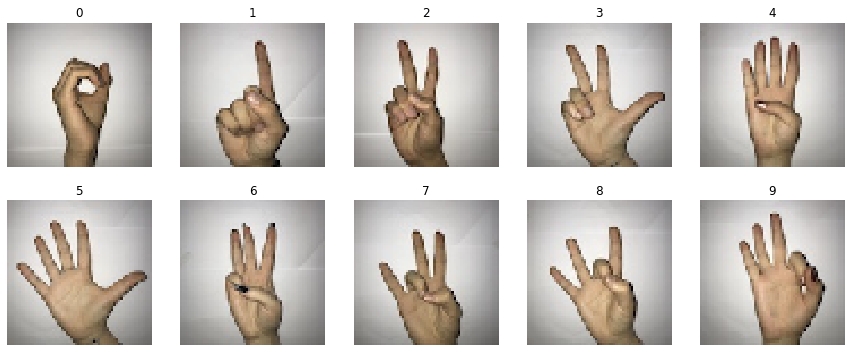

In [3]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3)
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        # load image
        img = image.load_img('D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Digits-Dataset-master\\Examples\\example_' + str(img_index) + '.JPG', target_size = (64, 64))
        plt.subplot(nrow, ncol, img_index + 1)
        plt.imshow(img)
        plt.title(img_index)
        plt.axis('off')

This project aims to create a classifier that can intepret sign language for number 0 to 9. The image of the sign language for respective number is shown above.

Inside 'Sign-Language-Digits-Dataset/Dataset/', the images of different sign language are organised according to their labels(i.e. 0 to 9). The dataset will first be divided into 3 sets : training_set, validation_set, and test_set. The size of training set, validation set, and test set are 70%, 15% and 15% of the whole dataset respectively.

To accomodate for the requirement for flow_from_directory method from keras, I will reorganise the images in the following structure :

* Training set : 'Sign-Language-Digits-Dataset/Dataset/training_set/class_00/image_file'
* Validation set : 'Sign-Language-Digits-Dataset/Dataset/validation_set/class_00/image_file'
* Test set : 'Sign-Language-Digits-Dataset/Dataset/test_set/class_00/image_file'

In [15]:
DATASET_PATH = 'D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Digits-Dataset-master\\Dataset'

In [17]:
# Creating a list of filename for training set, validation set, and test set
train_set = {}
validation_set = {}
test_set = {}
for cat in os.listdir(DATASET_PATH):
  cat_dir = os.path.join(DATASET_PATH, cat) # e.g. DATASET_PATH/'0'
  cat_files = os.listdir(cat_dir)
  # Training set's size is 70% of the data
  train_list , test_list = train_test_split(cat_files, test_size = 0.3)
  # Validation set's and Test set's size are both 15% of the data
  validation_list, test_list = train_test_split(test_list, test_size = 0.5)
  train_set[cat] = train_list
  validation_set[cat] = validation_list
  test_set[cat] = test_list

In [18]:
for cat in tqdm(train_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'training_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in train_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'training_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


In [19]:
for cat in tqdm(validation_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'validation_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in validation_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'validation_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


In [20]:
for cat in tqdm(test_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'test_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in test_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'test_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


In [21]:
for i in range(10):
  train_size = len(train_set[str(i)])
  validation_size = len(validation_set[str(i)])
  test_size = len(test_set[str(i)])
  print("0{} : Training size({}) Validation size({}) Test size({})".format(i, train_size, validation_size, test_size))

00 : Training size(143) Validation size(31) Test size(31)
01 : Training size(144) Validation size(31) Test size(31)
02 : Training size(144) Validation size(31) Test size(31)
03 : Training size(144) Validation size(31) Test size(31)
04 : Training size(144) Validation size(31) Test size(32)
05 : Training size(144) Validation size(31) Test size(32)
06 : Training size(144) Validation size(31) Test size(32)
07 : Training size(144) Validation size(31) Test size(31)
08 : Training size(145) Validation size(31) Test size(32)
09 : Training size(142) Validation size(31) Test size(31)


Data augmentation is performed on the training set images so that the classifier can learn any changes with respect to scaling, horizontal_flip, or others.

In [22]:
# Performing data augmentation on training dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# For validation dataset, only rescale the pictures
validation_datagen = ImageDataGenerator(rescale = 1./255)

# For test dataset, only rescale the pictures
test_datagen = ImageDataGenerator(rescale = 1./255)

training_data = train_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'training_set'),
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_data = validation_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'validation_set'),
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'test_set'),
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1438 images belonging to 10 classes.
Found 310 images belonging to 10 classes.
Found 314 images belonging to 10 classes.


For this dataset, I will be using the following infrastructure.



In [23]:
# Initialising the CNN
classifier = Sequential()

# Adding first convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding second convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding third convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# Train the data with training set, and check the result with validation accuracy
history = classifier.fit_generator(training_data,
                         steps_per_epoch = math.ceil(training_data.n / training_data.batch_size),
                         epochs = 100,
                         validation_data = validation_data,
                         validation_steps = math.ceil(validation_data.n / validation_data.batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 10 steps
Epoch 1/100
45/45 [==============================] - ETA: 1:19 - loss: 2.3867 - accuracy: 0.09 - ETA: 43s - loss: 2.3288 - accuracy: 0.1406 - ETA: 32s - loss: 2.3373 - accuracy: 0.156 - ETA: 26s - loss: 2.3164 - accuracy: 0.164 - ETA: 23s - loss: 2.3384 - accuracy: 0.156 - ETA: 21s - loss: 2.3487 - accuracy: 0.130 - ETA: 20s - loss: 2.3423 - accuracy: 0.125 - ETA: 19s - loss: 2.3390 - accuracy: 0.121 - ETA: 18s - loss: 2.3342 - accuracy: 0.125 - ETA: 18s - loss: 2.3366 - accuracy: 0.121 - ETA: 17s - loss: 2.3365 - accuracy: 0.119 - ETA: 16s - loss: 2.3350 - accuracy: 0.114 - ETA: 15s - loss: 2.3316 - accuracy: 0.115 - ETA: 14s - loss: 2.3308 - accuracy: 0.113 - ETA: 13s - loss: 2.3287 - accuracy: 0.110 - ETA: 13s - loss: 2.3262 - accuracy: 0.111 - ETA: 12s - loss: 2.3250 - accuracy: 0.106 - ETA: 11s - loss: 2.3241 - accu

45/45 [==============================] - ETA: 14s - loss: 0.7303 - accuracy: 0.781 - ETA: 11s - loss: 0.7046 - accuracy: 0.796 - ETA: 11s - loss: 0.8581 - accuracy: 0.760 - ETA: 10s - loss: 0.8196 - accuracy: 0.742 - ETA: 11s - loss: 0.8677 - accuracy: 0.750 - ETA: 10s - loss: 0.9500 - accuracy: 0.729 - ETA: 10s - loss: 0.9108 - accuracy: 0.736 - ETA: 10s - loss: 0.9098 - accuracy: 0.730 - ETA: 9s - loss: 0.9041 - accuracy: 0.732 - ETA: 9s - loss: 0.8839 - accuracy: 0.74 - ETA: 8s - loss: 0.8916 - accuracy: 0.73 - ETA: 8s - loss: 0.8949 - accuracy: 0.73 - ETA: 8s - loss: 0.8692 - accuracy: 0.74 - ETA: 7s - loss: 0.8667 - accuracy: 0.74 - ETA: 7s - loss: 0.8623 - accuracy: 0.74 - ETA: 7s - loss: 0.8798 - accuracy: 0.74 - ETA: 7s - loss: 0.9018 - accuracy: 0.72 - ETA: 6s - loss: 0.8917 - accuracy: 0.73 - ETA: 6s - loss: 0.8877 - accuracy: 0.73 - ETA: 6s - loss: 0.8956 - accuracy: 0.73 - ETA: 5s - loss: 0.8984 - accuracy: 0.72 - ETA: 5s - loss: 0.9030 - accuracy: 0.72 - ETA: 5s - loss: 0.

45/45 [==============================] - ETA: 13s - loss: 0.6571 - accuracy: 0.781 - ETA: 11s - loss: 0.5722 - accuracy: 0.765 - ETA: 10s - loss: 0.5558 - accuracy: 0.781 - ETA: 10s - loss: 0.5305 - accuracy: 0.796 - ETA: 9s - loss: 0.5236 - accuracy: 0.800 - ETA: 9s - loss: 0.5211 - accuracy: 0.81 - ETA: 9s - loss: 0.5290 - accuracy: 0.80 - ETA: 9s - loss: 0.5083 - accuracy: 0.82 - ETA: 8s - loss: 0.5414 - accuracy: 0.82 - ETA: 8s - loss: 0.5248 - accuracy: 0.82 - ETA: 8s - loss: 0.5262 - accuracy: 0.82 - ETA: 8s - loss: 0.5259 - accuracy: 0.81 - ETA: 7s - loss: 0.5085 - accuracy: 0.81 - ETA: 7s - loss: 0.4897 - accuracy: 0.82 - ETA: 7s - loss: 0.5057 - accuracy: 0.82 - ETA: 7s - loss: 0.5121 - accuracy: 0.81 - ETA: 6s - loss: 0.5014 - accuracy: 0.82 - ETA: 6s - loss: 0.4964 - accuracy: 0.82 - ETA: 6s - loss: 0.5024 - accuracy: 0.82 - ETA: 6s - loss: 0.5025 - accuracy: 0.82 - ETA: 5s - loss: 0.5044 - accuracy: 0.82 - ETA: 5s - loss: 0.5076 - accuracy: 0.82 - ETA: 5s - loss: 0.5199 - a

45/45 [==============================] - ETA: 12s - loss: 0.4796 - accuracy: 0.906 - ETA: 12s - loss: 0.3827 - accuracy: 0.906 - ETA: 11s - loss: 0.3520 - accuracy: 0.895 - ETA: 10s - loss: 0.3441 - accuracy: 0.898 - ETA: 10s - loss: 0.3498 - accuracy: 0.893 - ETA: 10s - loss: 0.3513 - accuracy: 0.890 - ETA: 10s - loss: 0.3566 - accuracy: 0.892 - ETA: 9s - loss: 0.3431 - accuracy: 0.894 - ETA: 9s - loss: 0.3540 - accuracy: 0.88 - ETA: 8s - loss: 0.3341 - accuracy: 0.89 - ETA: 8s - loss: 0.3429 - accuracy: 0.88 - ETA: 8s - loss: 0.3282 - accuracy: 0.89 - ETA: 8s - loss: 0.3110 - accuracy: 0.89 - ETA: 8s - loss: 0.3109 - accuracy: 0.89 - ETA: 7s - loss: 0.3201 - accuracy: 0.89 - ETA: 7s - loss: 0.3070 - accuracy: 0.90 - ETA: 7s - loss: 0.2980 - accuracy: 0.90 - ETA: 7s - loss: 0.2966 - accuracy: 0.90 - ETA: 7s - loss: 0.3005 - accuracy: 0.90 - ETA: 6s - loss: 0.3025 - accuracy: 0.90 - ETA: 6s - loss: 0.3121 - accuracy: 0.90 - ETA: 6s - loss: 0.3183 - accuracy: 0.90 - ETA: 6s - loss: 0.32

45/45 [==============================] - ETA: 13s - loss: 0.2396 - accuracy: 0.875 - ETA: 11s - loss: 0.2255 - accuracy: 0.906 - ETA: 10s - loss: 0.2393 - accuracy: 0.906 - ETA: 10s - loss: 0.2703 - accuracy: 0.890 - ETA: 9s - loss: 0.2664 - accuracy: 0.900 - ETA: 9s - loss: 0.2751 - accuracy: 0.90 - ETA: 8s - loss: 0.2704 - accuracy: 0.91 - ETA: 8s - loss: 0.2438 - accuracy: 0.92 - ETA: 8s - loss: 0.2397 - accuracy: 0.92 - ETA: 8s - loss: 0.2284 - accuracy: 0.92 - ETA: 7s - loss: 0.2232 - accuracy: 0.92 - ETA: 7s - loss: 0.2335 - accuracy: 0.91 - ETA: 7s - loss: 0.2324 - accuracy: 0.91 - ETA: 7s - loss: 0.2253 - accuracy: 0.91 - ETA: 6s - loss: 0.2228 - accuracy: 0.92 - ETA: 6s - loss: 0.2270 - accuracy: 0.92 - ETA: 6s - loss: 0.2237 - accuracy: 0.92 - ETA: 6s - loss: 0.2411 - accuracy: 0.92 - ETA: 6s - loss: 0.2352 - accuracy: 0.92 - ETA: 5s - loss: 0.2316 - accuracy: 0.92 - ETA: 5s - loss: 0.2298 - accuracy: 0.92 - ETA: 5s - loss: 0.2269 - accuracy: 0.92 - ETA: 5s - loss: 0.2250 - a

45/45 [==============================] - ETA: 23s - loss: 0.0660 - accuracy: 0.968 - ETA: 18s - loss: 0.1328 - accuracy: 0.953 - ETA: 15s - loss: 0.1065 - accuracy: 0.958 - ETA: 13s - loss: 0.1617 - accuracy: 0.929 - ETA: 12s - loss: 0.1412 - accuracy: 0.943 - ETA: 12s - loss: 0.1363 - accuracy: 0.947 - ETA: 11s - loss: 0.1343 - accuracy: 0.942 - ETA: 11s - loss: 0.1494 - accuracy: 0.933 - ETA: 10s - loss: 0.1507 - accuracy: 0.934 - ETA: 10s - loss: 0.1481 - accuracy: 0.937 - ETA: 9s - loss: 0.1453 - accuracy: 0.940 - ETA: 9s - loss: 0.1370 - accuracy: 0.94 - ETA: 9s - loss: 0.1477 - accuracy: 0.94 - ETA: 8s - loss: 0.1444 - accuracy: 0.94 - ETA: 8s - loss: 0.1453 - accuracy: 0.94 - ETA: 8s - loss: 0.1594 - accuracy: 0.93 - ETA: 7s - loss: 0.1581 - accuracy: 0.93 - ETA: 7s - loss: 0.1555 - accuracy: 0.94 - ETA: 7s - loss: 0.1585 - accuracy: 0.94 - ETA: 6s - loss: 0.1545 - accuracy: 0.94 - ETA: 6s - loss: 0.1577 - accuracy: 0.94 - ETA: 6s - loss: 0.1548 - accuracy: 0.94 - ETA: 6s - loss

45/45 [==============================] - ETA: 24s - loss: 0.0562 - accuracy: 1.000 - ETA: 17s - loss: 0.0528 - accuracy: 1.000 - ETA: 15s - loss: 0.0669 - accuracy: 0.989 - ETA: 14s - loss: 0.1192 - accuracy: 0.968 - ETA: 13s - loss: 0.1196 - accuracy: 0.962 - ETA: 12s - loss: 0.1250 - accuracy: 0.958 - ETA: 11s - loss: 0.1149 - accuracy: 0.964 - ETA: 11s - loss: 0.1256 - accuracy: 0.957 - ETA: 10s - loss: 0.1361 - accuracy: 0.947 - ETA: 10s - loss: 0.1365 - accuracy: 0.950 - ETA: 9s - loss: 0.1484 - accuracy: 0.946 - ETA: 9s - loss: 0.1494 - accuracy: 0.94 - ETA: 9s - loss: 0.1504 - accuracy: 0.94 - ETA: 8s - loss: 0.1485 - accuracy: 0.94 - ETA: 8s - loss: 0.1444 - accuracy: 0.95 - ETA: 8s - loss: 0.1407 - accuracy: 0.95 - ETA: 7s - loss: 0.1422 - accuracy: 0.95 - ETA: 7s - loss: 0.1394 - accuracy: 0.95 - ETA: 7s - loss: 0.1361 - accuracy: 0.95 - ETA: 6s - loss: 0.1386 - accuracy: 0.95 - ETA: 6s - loss: 0.1411 - accuracy: 0.95 - ETA: 6s - loss: 0.1452 - accuracy: 0.95 - ETA: 5s - loss

45/45 [==============================] - ETA: 14s - loss: 0.1552 - accuracy: 0.906 - ETA: 12s - loss: 0.1686 - accuracy: 0.921 - ETA: 11s - loss: 0.1273 - accuracy: 0.937 - ETA: 12s - loss: 0.1027 - accuracy: 0.953 - ETA: 11s - loss: 0.1043 - accuracy: 0.943 - ETA: 11s - loss: 0.1093 - accuracy: 0.947 - ETA: 10s - loss: 0.1054 - accuracy: 0.946 - ETA: 10s - loss: 0.1160 - accuracy: 0.941 - ETA: 10s - loss: 0.1178 - accuracy: 0.941 - ETA: 9s - loss: 0.1363 - accuracy: 0.937 - ETA: 9s - loss: 0.1252 - accuracy: 0.94 - ETA: 8s - loss: 0.1239 - accuracy: 0.94 - ETA: 8s - loss: 0.1190 - accuracy: 0.94 - ETA: 8s - loss: 0.1129 - accuracy: 0.95 - ETA: 8s - loss: 0.1096 - accuracy: 0.95 - ETA: 8s - loss: 0.1040 - accuracy: 0.95 - ETA: 8s - loss: 0.0988 - accuracy: 0.95 - ETA: 7s - loss: 0.0936 - accuracy: 0.96 - ETA: 7s - loss: 0.0927 - accuracy: 0.96 - ETA: 7s - loss: 0.0933 - accuracy: 0.96 - ETA: 6s - loss: 0.1011 - accuracy: 0.95 - ETA: 6s - loss: 0.1045 - accuracy: 0.96 - ETA: 6s - loss: 

45/45 [==============================] - ETA: 13s - loss: 0.1215 - accuracy: 0.968 - ETA: 13s - loss: 0.1582 - accuracy: 0.968 - ETA: 12s - loss: 0.1302 - accuracy: 0.968 - ETA: 11s - loss: 0.1165 - accuracy: 0.968 - ETA: 11s - loss: 0.1572 - accuracy: 0.950 - ETA: 10s - loss: 0.1520 - accuracy: 0.953 - ETA: 10s - loss: 0.1489 - accuracy: 0.950 - ETA: 9s - loss: 0.1594 - accuracy: 0.949 - ETA: 9s - loss: 0.1538 - accuracy: 0.94 - ETA: 9s - loss: 0.1453 - accuracy: 0.95 - ETA: 9s - loss: 0.1394 - accuracy: 0.94 - ETA: 8s - loss: 0.1300 - accuracy: 0.95 - ETA: 8s - loss: 0.1332 - accuracy: 0.95 - ETA: 8s - loss: 0.1319 - accuracy: 0.95 - ETA: 8s - loss: 0.1249 - accuracy: 0.95 - ETA: 7s - loss: 0.1219 - accuracy: 0.95 - ETA: 7s - loss: 0.1247 - accuracy: 0.95 - ETA: 7s - loss: 0.1213 - accuracy: 0.96 - ETA: 7s - loss: 0.1198 - accuracy: 0.96 - ETA: 7s - loss: 0.1233 - accuracy: 0.95 - ETA: 6s - loss: 0.1192 - accuracy: 0.96 - ETA: 6s - loss: 0.1167 - accuracy: 0.96 - ETA: 6s - loss: 0.11

45/45 [==============================] - ETA: 15s - loss: 0.0679 - accuracy: 0.937 - ETA: 12s - loss: 0.0626 - accuracy: 0.968 - ETA: 11s - loss: 0.0751 - accuracy: 0.958 - ETA: 11s - loss: 0.0950 - accuracy: 0.960 - ETA: 10s - loss: 0.0916 - accuracy: 0.962 - ETA: 10s - loss: 0.0808 - accuracy: 0.968 - ETA: 10s - loss: 0.0834 - accuracy: 0.968 - ETA: 10s - loss: 0.0768 - accuracy: 0.972 - ETA: 10s - loss: 0.0698 - accuracy: 0.975 - ETA: 10s - loss: 0.0763 - accuracy: 0.975 - ETA: 9s - loss: 0.0783 - accuracy: 0.974 - ETA: 9s - loss: 0.0850 - accuracy: 0.97 - ETA: 8s - loss: 0.0879 - accuracy: 0.96 - ETA: 8s - loss: 0.0866 - accuracy: 0.96 - ETA: 8s - loss: 0.0936 - accuracy: 0.96 - ETA: 7s - loss: 0.0933 - accuracy: 0.96 - ETA: 7s - loss: 0.0925 - accuracy: 0.96 - ETA: 7s - loss: 0.0889 - accuracy: 0.96 - ETA: 6s - loss: 0.0846 - accuracy: 0.96 - ETA: 6s - loss: 0.0830 - accuracy: 0.96 - ETA: 6s - loss: 0.0866 - accuracy: 0.96 - ETA: 6s - loss: 0.0843 - accuracy: 0.97 - ETA: 5s - loss

45/45 [==============================] - ETA: 16s - loss: 0.0379 - accuracy: 0.968 - ETA: 13s - loss: 0.0360 - accuracy: 0.984 - ETA: 12s - loss: 0.0678 - accuracy: 0.968 - ETA: 11s - loss: 0.0764 - accuracy: 0.968 - ETA: 11s - loss: 0.0900 - accuracy: 0.968 - ETA: 10s - loss: 0.0977 - accuracy: 0.968 - ETA: 10s - loss: 0.0894 - accuracy: 0.968 - ETA: 11s - loss: 0.0795 - accuracy: 0.972 - ETA: 10s - loss: 0.0761 - accuracy: 0.972 - ETA: 10s - loss: 0.0720 - accuracy: 0.975 - ETA: 10s - loss: 0.0708 - accuracy: 0.974 - ETA: 10s - loss: 0.0741 - accuracy: 0.974 - ETA: 9s - loss: 0.0938 - accuracy: 0.968 - ETA: 9s - loss: 0.0957 - accuracy: 0.96 - ETA: 8s - loss: 0.1065 - accuracy: 0.96 - ETA: 8s - loss: 0.1214 - accuracy: 0.95 - ETA: 8s - loss: 0.1186 - accuracy: 0.95 - ETA: 7s - loss: 0.1135 - accuracy: 0.95 - ETA: 7s - loss: 0.1129 - accuracy: 0.95 - ETA: 7s - loss: 0.1078 - accuracy: 0.95 - ETA: 6s - loss: 0.1142 - accuracy: 0.95 - ETA: 6s - loss: 0.1096 - accuracy: 0.96 - ETA: 6s - 

45/45 [==============================] - ETA: 14s - loss: 0.0179 - accuracy: 1.000 - ETA: 12s - loss: 0.0521 - accuracy: 0.984 - ETA: 11s - loss: 0.0364 - accuracy: 0.989 - ETA: 13s - loss: 0.0371 - accuracy: 0.984 - ETA: 12s - loss: 0.0302 - accuracy: 0.987 - ETA: 11s - loss: 0.0292 - accuracy: 0.989 - ETA: 10s - loss: 0.0278 - accuracy: 0.991 - ETA: 10s - loss: 0.0326 - accuracy: 0.988 - ETA: 10s - loss: 0.0367 - accuracy: 0.986 - ETA: 9s - loss: 0.0351 - accuracy: 0.987 - ETA: 9s - loss: 0.0513 - accuracy: 0.97 - ETA: 9s - loss: 0.0534 - accuracy: 0.97 - ETA: 8s - loss: 0.0545 - accuracy: 0.97 - ETA: 9s - loss: 0.0538 - accuracy: 0.97 - ETA: 8s - loss: 0.0514 - accuracy: 0.97 - ETA: 8s - loss: 0.0567 - accuracy: 0.97 - ETA: 8s - loss: 0.0539 - accuracy: 0.97 - ETA: 7s - loss: 0.0529 - accuracy: 0.97 - ETA: 7s - loss: 0.0506 - accuracy: 0.98 - ETA: 7s - loss: 0.0535 - accuracy: 0.97 - ETA: 6s - loss: 0.0552 - accuracy: 0.97 - ETA: 6s - loss: 0.0548 - accuracy: 0.97 - ETA: 6s - loss: 

45/45 [==============================] - ETA: 15s - loss: 0.0094 - accuracy: 1.000 - ETA: 11s - loss: 0.0457 - accuracy: 0.984 - ETA: 11s - loss: 0.0852 - accuracy: 0.958 - ETA: 10s - loss: 0.0679 - accuracy: 0.968 - ETA: 10s - loss: 0.0545 - accuracy: 0.975 - ETA: 9s - loss: 0.0506 - accuracy: 0.979 - ETA: 9s - loss: 0.0723 - accuracy: 0.97 - ETA: 9s - loss: 0.0866 - accuracy: 0.97 - ETA: 8s - loss: 0.0919 - accuracy: 0.97 - ETA: 8s - loss: 0.0869 - accuracy: 0.97 - ETA: 8s - loss: 0.0825 - accuracy: 0.97 - ETA: 7s - loss: 0.0766 - accuracy: 0.97 - ETA: 8s - loss: 0.0726 - accuracy: 0.97 - ETA: 7s - loss: 0.0710 - accuracy: 0.97 - ETA: 7s - loss: 0.0684 - accuracy: 0.98 - ETA: 7s - loss: 0.0741 - accuracy: 0.97 - ETA: 6s - loss: 0.0717 - accuracy: 0.97 - ETA: 6s - loss: 0.0713 - accuracy: 0.97 - ETA: 6s - loss: 0.0685 - accuracy: 0.97 - ETA: 6s - loss: 0.0670 - accuracy: 0.97 - ETA: 5s - loss: 0.0650 - accuracy: 0.97 - ETA: 5s - loss: 0.0632 - accuracy: 0.98 - ETA: 5s - loss: 0.0613 -

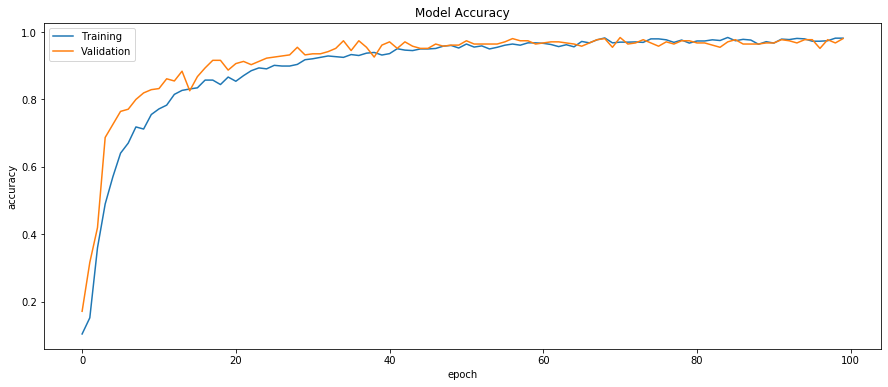

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])

From the accuracy plot, the validation accuracy differs from the training accuracy by a small extent indicating absence of overfitting. When the classifier is evaluated on the test set, it obtains a relatively high accuracy.

In [26]:
# Accuracy of the classifier when evaluated based on the test_set
test_loss, test_accuracy = classifier.evaluate_generator(test_data, math.ceil(test_data.n / test_data.batch_size))
print("Accuracy on test set : {}".format(test_accuracy))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Accuracy on test set : 0.9745222926139832


To visualise the performance of the classifier, the classifier will be used to predict all the example images for 0 to 9.

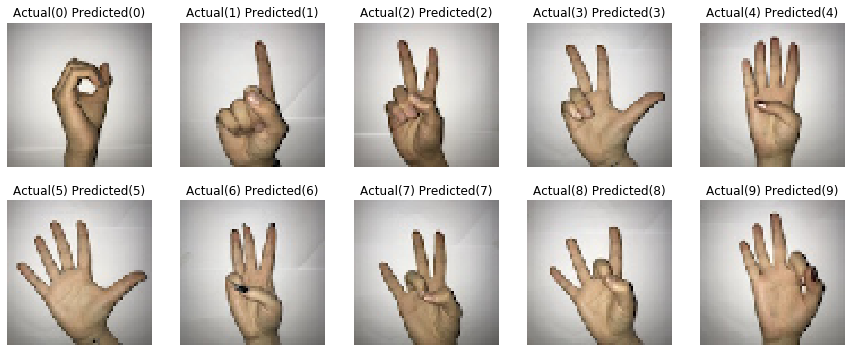

In [27]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3)
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        # load image
        img = image.load_img('D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Digits-Dataset-master\\Examples\\example_' + str(img_index) + '.JPG', target_size = (64, 64))
        # convert image into array for prediction
        test_image = image.img_to_array(img)
        test_image = np.expand_dims(test_image, axis = 0)
        # predict image using classifier
        result = classifier.predict(test_image).argmax()
        plt.subplot(nrow, ncol, img_index + 1)
        plt.imshow(img)
        plt.title("Actual({}) Predicted({})".format(img_index, result))
        plt.axis('off')

It can be seen from above output that the classifier is able to classify all the images correctly. To save the model for future use, simply run the code below.

In [29]:
#saving tensorflow model
import tensorflow as tf
export_dir='D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Detection-master\\tmp\\saved_model'
tf.saved_model.save(classifier,export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Qamous\CODES\digits\New_Model\Sign-Language-Detection-master\tmp\saved_model\assets


In [37]:
#loading tensorflow model
model=tf.keras.models.load_model('D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Detection-master\\tmp\\saved_model')


the predicted character is:  9


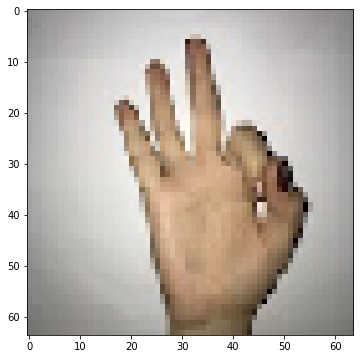

In [42]:
#read an image from test data and test the model
# load image
img = image.load_img('D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Digits-Dataset-master\\Examples\\example_9.JPG', target_size = (64, 64))
# convert image into array for prediction
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)
# predict image using classifier
result = model.predict(test_image).argmax()
plt.imshow(img)
print("\nthe predicted character is: ",result)


the predicted character is:  5


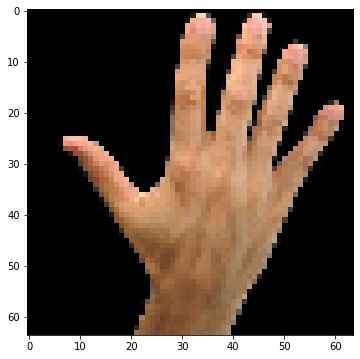

In [49]:
#read an image from  and test the model
# convert image from (320, 320, 3) to (64,64,3)
from PIL import Image
img=Image.open('D:\\Qamous\\CODES\\digits\\examples\\number05.jpg')
img=img.resize((64,64))
# convert image into array for prediction
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)
# predict image using classifier
result = model.predict(test_image).argmax()
plt.imshow(img)
print("\nthe predicted character is: ",result)

In [50]:
#TensorFlow Lite converter
saved_model_dir='D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Detection-master\\tmp\\saved_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

In [51]:
#save the converted model
open("D:\\Qamous\\CODES\\digits\\New_Model\\Sign-Language-Detection-master\\tmp\\converted_model.tflite", "wb").write(tflite_model)


676424